# PHẦN MÔ HÌNH TRỘN GAUSSIAN

### Bai tap tu thuc hanh 1

In [3]:
import numpy as np
from numpy import random
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import multivariate_normal

class GMM():
    def __init__(self, k, dim, init_mu=None, init_sigma=None, init_pi=None, colors=None):
        '''
        Define a model with known number of clusters and dimensions.
        input:
            - k: Number of Gaussian clusters
            - dim: Dimension 
            - init_mu: initial value of mean of clusters (k, dim)
                       (default) random from uniform[-10, 10]
            - init_sigma: initial value of covariance matrix of clusters (k, dim, dim)
                          (default) Identity matrix for each cluster
            - init_pi: initial value of cluster weights (k,)
                       (default) equal value to all cluster i.e. 1/k
            - colors: Color valu for plotting each cluster (k, 3)
                      (default) random from uniform[0, 1]
        '''
        self.k = k
        self.dim = dim
        if(init_mu is None):
            init_mu = random.rand(k, dim)*20 - 10
        self.mu = init_mu
        if(init_sigma is None):
            init_sigma = np.zeros((k, dim, dim))
            for i in range(k):
                init_sigma[i] = np.eye(dim)
        self.sigma = init_sigma
        if(init_pi is None):
            init_pi = np.ones(self.k)/self.k
        self.pi = init_pi
        if(colors is None):
            colors = random.rand(k, 3)
            for i in range(k):
                colors[i, 2] = i/k
        self.colors = colors
    
    def init_em(self, X):
        '''
        Initialization for EM algorithm.
        input:
            - X: data (batch_size, dim)
        '''
        self.data = X
        self.num_points = X.shape[0]
        self.z = np.zeros((self.num_points, self.k))
    
    def e_step(self):
        '''
        E-step of EM algorithm.
        '''
        for i in range(self.k):
            self.z[:, i] = self.pi[i] * multivariate_normal.pdf(self.data, mean=self.mu[i], cov=self.sigma[i])
        self.z /= self.z.sum(axis=1, keepdims=True)
    
    def m_step(self):
        '''
        M-step of EM algorithm.
        '''
        sum_z = self.z.sum(axis=0)
        self.pi = sum_z / self.num_points
        self.mu = np.matmul(self.z.T, self.data)
        self.mu /= sum_z[:, None]
        for i in range(self.k):
            j = np.expand_dims(self.data, axis=1) - self.mu[i]
            s = np.matmul(j.transpose([0, 2, 1]), j)
            self.sigma[i] = np.matmul(s.transpose(1, 2, 0), self.z[:, i] )
            self.sigma[i] /= sum_z[i]
            
    def log_likelihood(self, X):
        '''
        Compute the log-likelihood of X under current parameters
        input:
            - X: Data (batch_size, dim)
        output:
            - log-likelihood of X: Sum_n Sum_k log(pi_k * N( X_n | mu_k, sigma_k ))
        '''
        ll = []
        for d in X:
            tot = 0
            for i in range(self.k):
                tot += self.pi[i] * multivariate_normal.pdf(d, mean=self.mu[i], cov=self.sigma[i])
            ll.append(np.log(tot))
        return np.sum(ll)
    
    def plot_gaussian(self, mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
        '''
        Utility function to plot one Gaussian from mean and covariance.
        '''
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0),
            width=ell_radius_x * 2,
            height=ell_radius_y * 2,
            facecolor=facecolor,
            **kwargs)
        scale_x = np.sqrt(cov[0, 0]) * n_std
        mean_x = mean[0]
        scale_y = np.sqrt(cov[1, 1]) * n_std
        mean_y = mean[1]
        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)
        ellipse.set_transform(transf + ax.transData)
        return ax.add_patch(ellipse)

    def draw(self, ax, n_std=2.0, facecolor='none', **kwargs):
        '''
        Function to draw the Gaussians.
        Note: Only for two-dimensionl dataset
        '''
        if(self.dim != 2):
            print("Drawing available only for 2D case.")
            return
        for i in range(self.k):
            self.plot_gaussian(self.mu[i], self.sigma[i], ax, n_std=n_std, edgecolor=self.colors[i], **kwargs)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal


In [5]:
def gen_data(k=3, dim=2, points_per_cluster=200, lim=[-10, 10]):
    '''
    Generates data from a random mixture of Gaussians in a given range.
    Will also plot the points in case of 2D.
    input:
        - k: Number of Gaussian clusters
        - dim: Dimension of generated points
        - points_per_cluster: Number of points to be generated for each cluster
        - lim: Range of mean values
    output:
        - X: Generated points (points_per_cluster*k, dim)
    '''
    x = []
    mean = random.rand(k, dim)*(lim[1]-lim[0]) + lim[0]
    for i in range(k):
        cov = random.rand(dim, dim+10)
        cov = np.matmul(cov, cov.T)
        _x = np.random.multivariate_normal(mean[i], cov, points_per_cluster)
        x += list(_x)
    x = np.array(x)
    if(dim == 2):
        fig = plt.figure()
        ax = fig.gca()
        ax.scatter(x[:,0], x[:,1], s=3, alpha=0.4)
        ax.autoscale(enable=True) 
    return x

In [6]:
def plot(title):
    '''
    Draw the data points and the fitted mixture model.
    input:
        - title: title of plot and name with which it will be saved.
    '''
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    ax.scatter(X[:, 0], X[:, 1], s=3, alpha=0.4)
    ax.scatter(gmm.mu[:, 0], gmm.mu[:, 1], c=gmm.colors)
    gmm.draw(ax, lw=3)
    ax.set_xlim((-22, 22))
    ax.set_ylim((-22, 22))
    
    plt.title(title)
    plt.savefig(title.replace(':', '_'))
    plt.show()
    plt.clf()

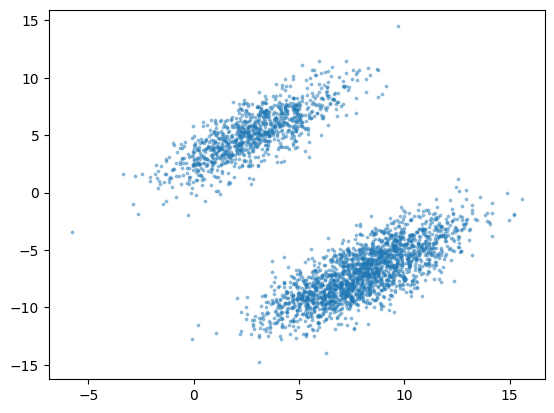

In [7]:
# Generate random 2D data with 3 clusters 
X = gen_data(k=3, dim=2, points_per_cluster=1000)

In [8]:
# Create a Gaussian Mixture Model
gmm = GMM(3, 2)

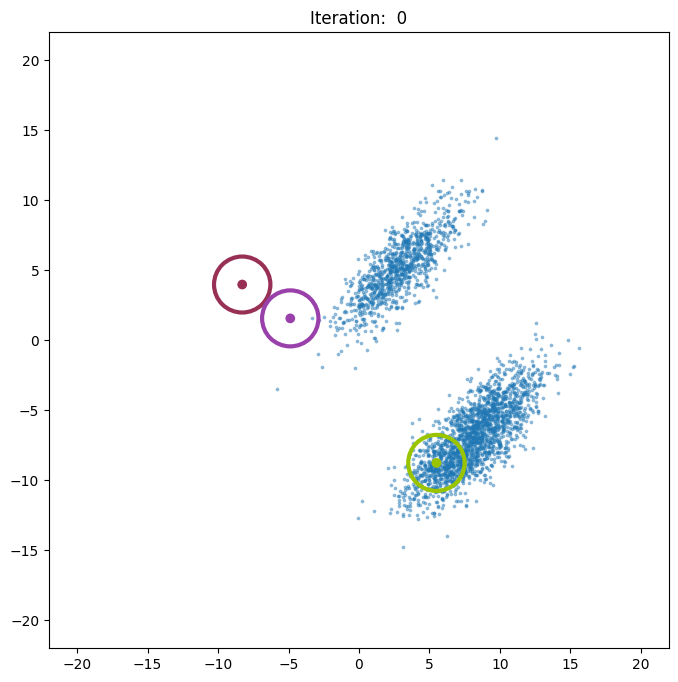

Iteration: 1, log-likelihood: -14017.8592


<Figure size 640x480 with 0 Axes>

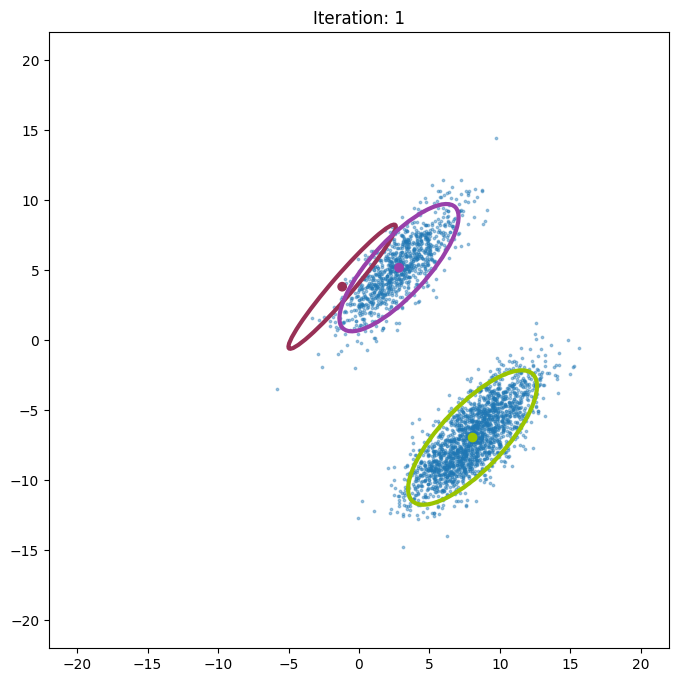

Iteration: 2, log-likelihood: -14017.8592


<Figure size 640x480 with 0 Axes>

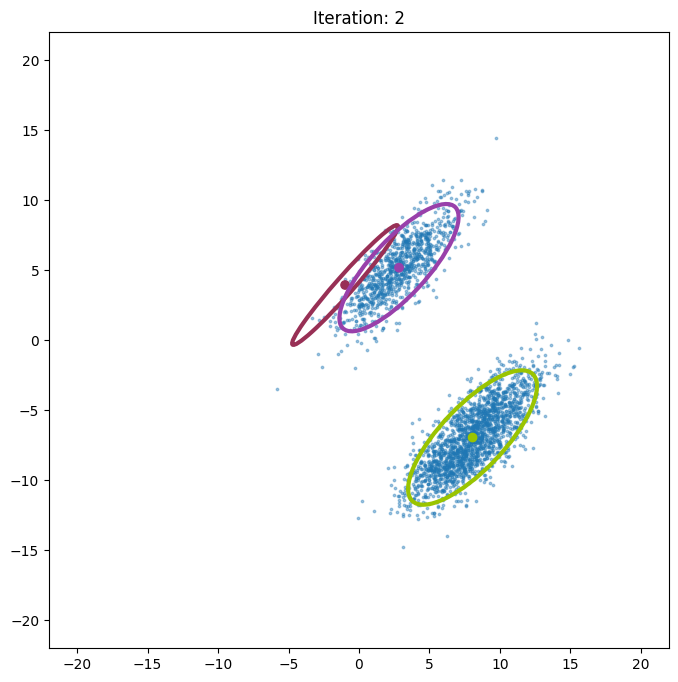

Iteration: 3, log-likelihood: -14017.8592


<Figure size 640x480 with 0 Axes>

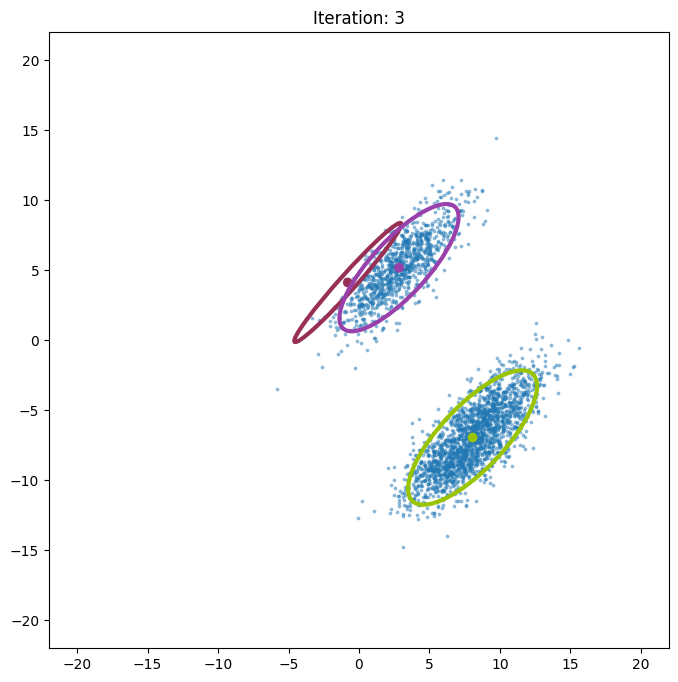

Iteration: 4, log-likelihood: -14017.8592


<Figure size 640x480 with 0 Axes>

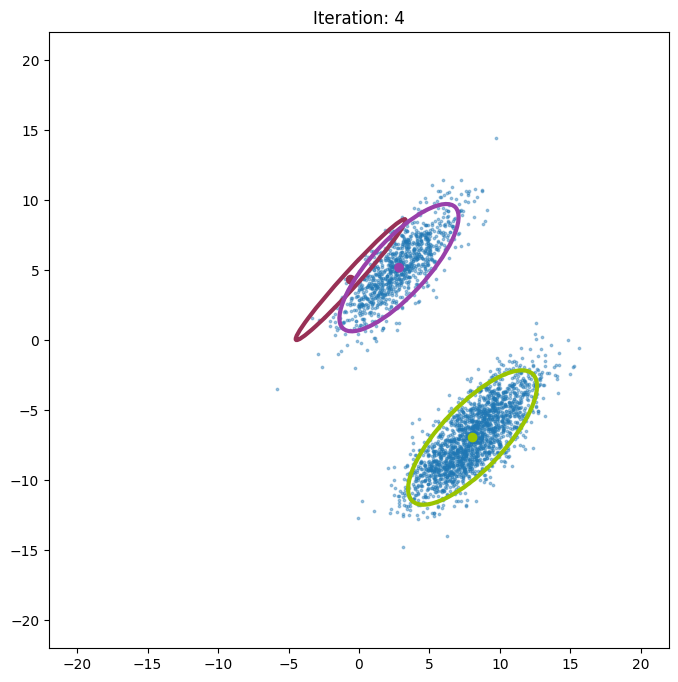

Iteration: 5, log-likelihood: -14017.8592


<Figure size 640x480 with 0 Axes>

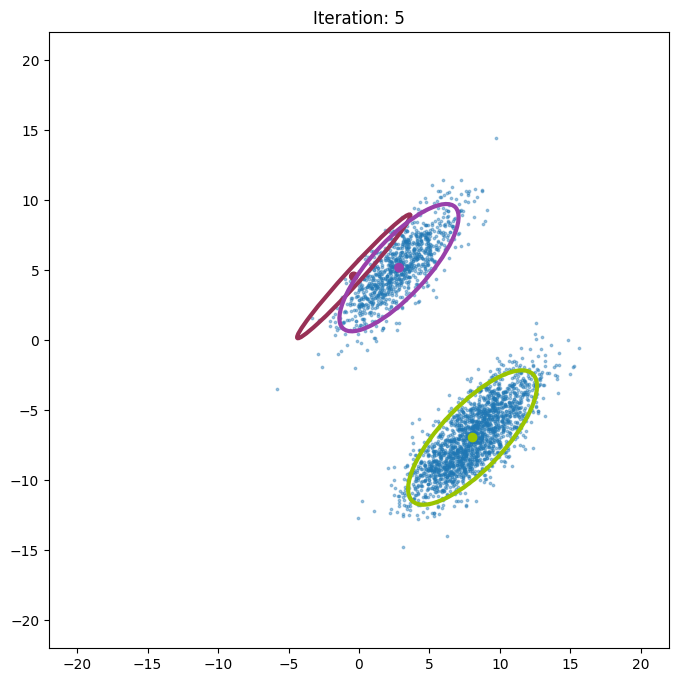

Iteration: 6, log-likelihood: -14017.8592


<Figure size 640x480 with 0 Axes>

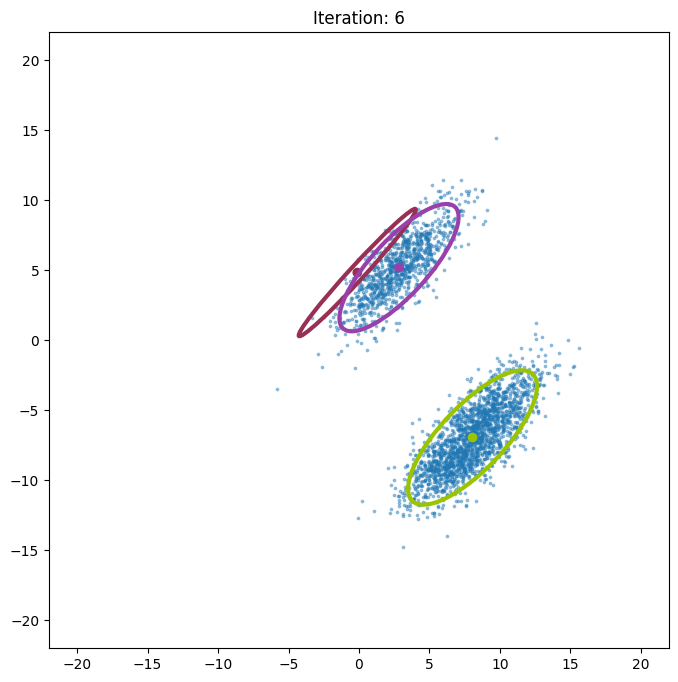

Iteration: 7, log-likelihood: -14017.8592


<Figure size 640x480 with 0 Axes>

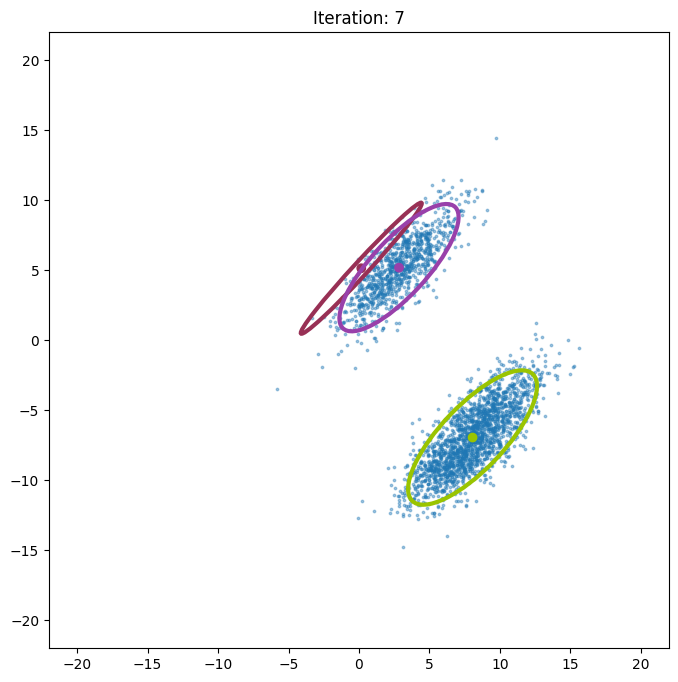

Iteration: 8, log-likelihood: -14017.8592


<Figure size 640x480 with 0 Axes>

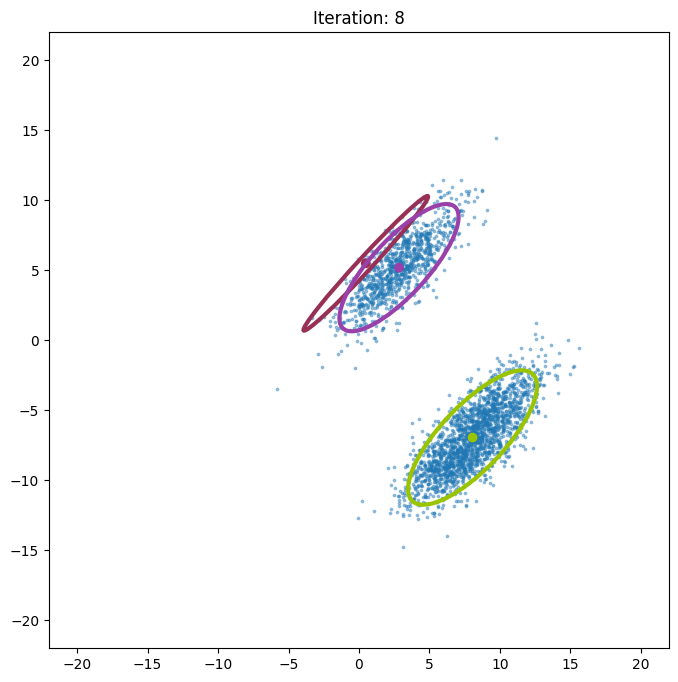

Iteration: 9, log-likelihood: -14017.8592


<Figure size 640x480 with 0 Axes>

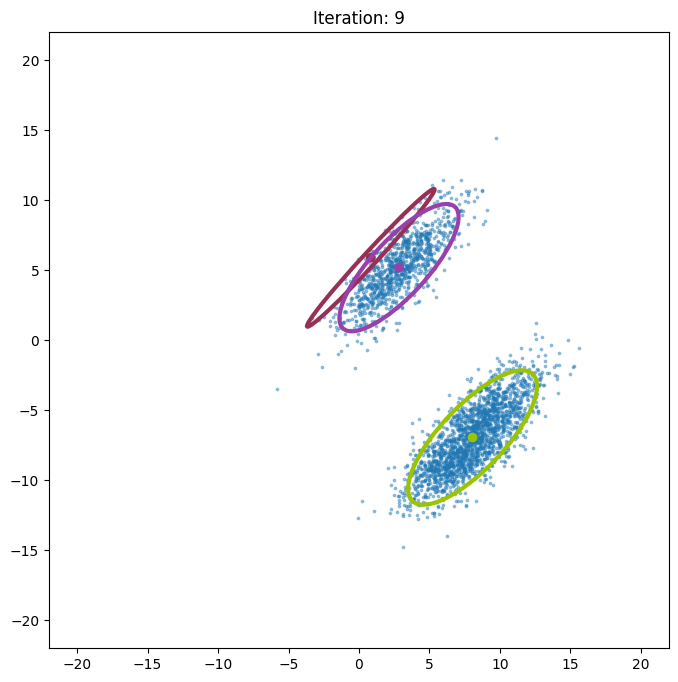

Iteration: 10, log-likelihood: -14017.8592


<Figure size 640x480 with 0 Axes>

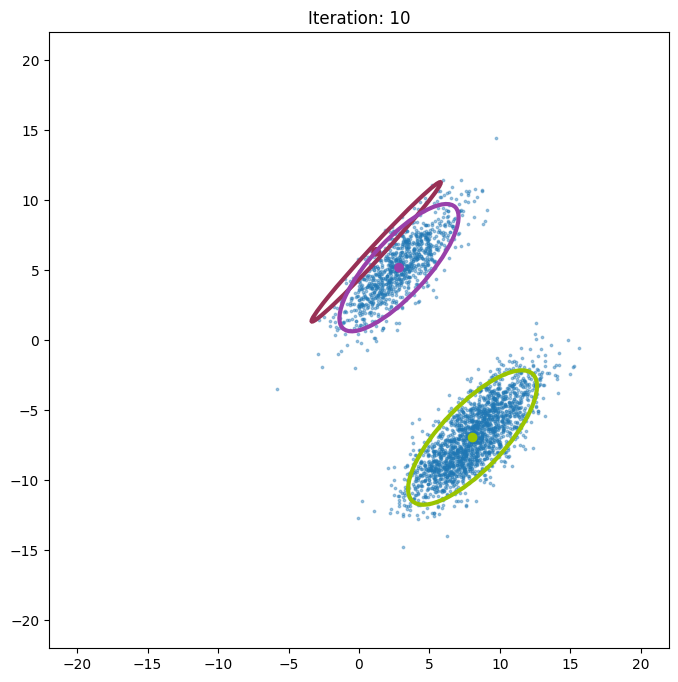

Iteration: 11, log-likelihood: -14017.8592


<Figure size 640x480 with 0 Axes>

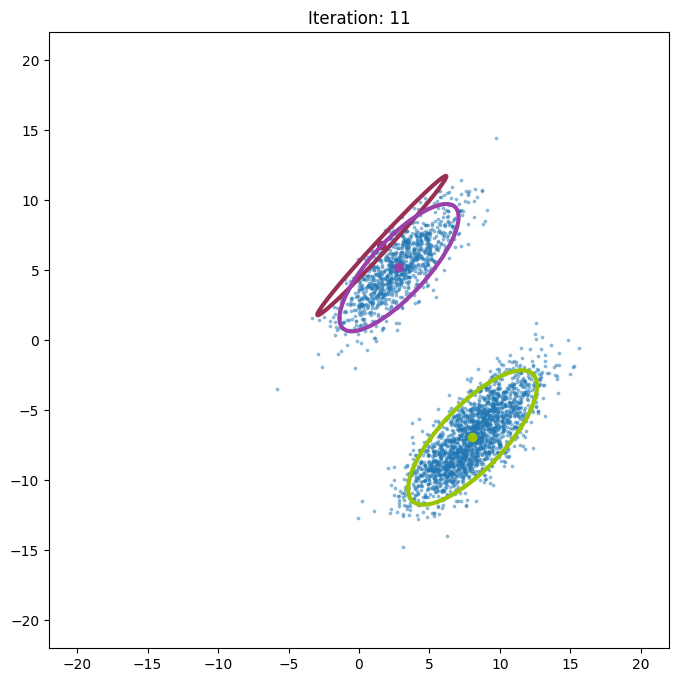

Iteration: 12, log-likelihood: -14017.8592


<Figure size 640x480 with 0 Axes>

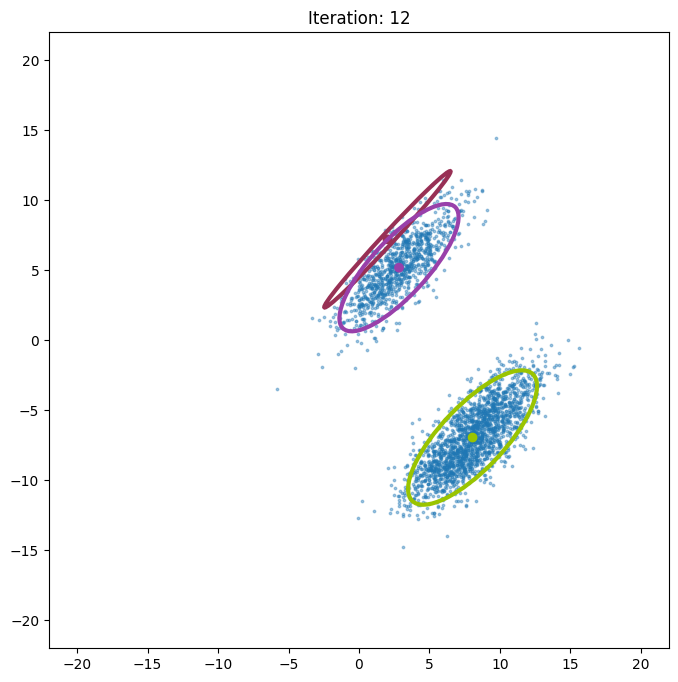

Iteration: 13, log-likelihood: -14017.8592


<Figure size 640x480 with 0 Axes>

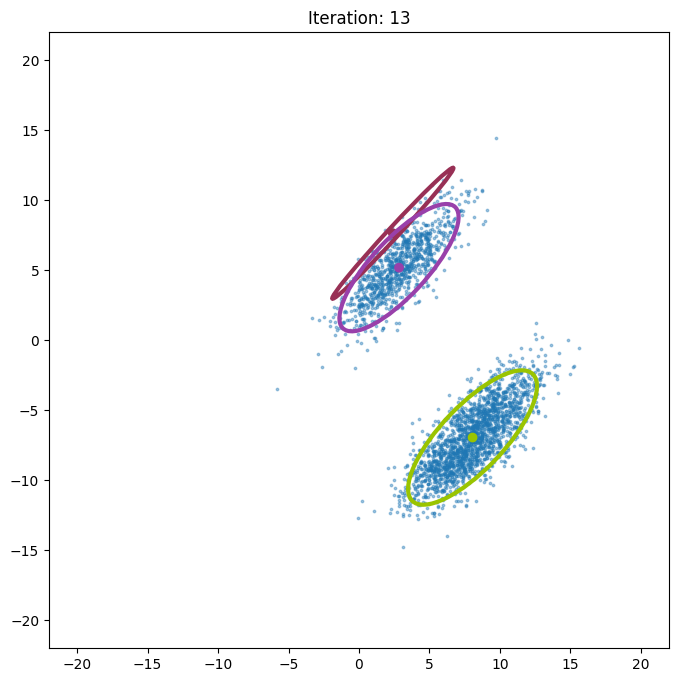

Iteration: 14, log-likelihood: -14017.8592


<Figure size 640x480 with 0 Axes>

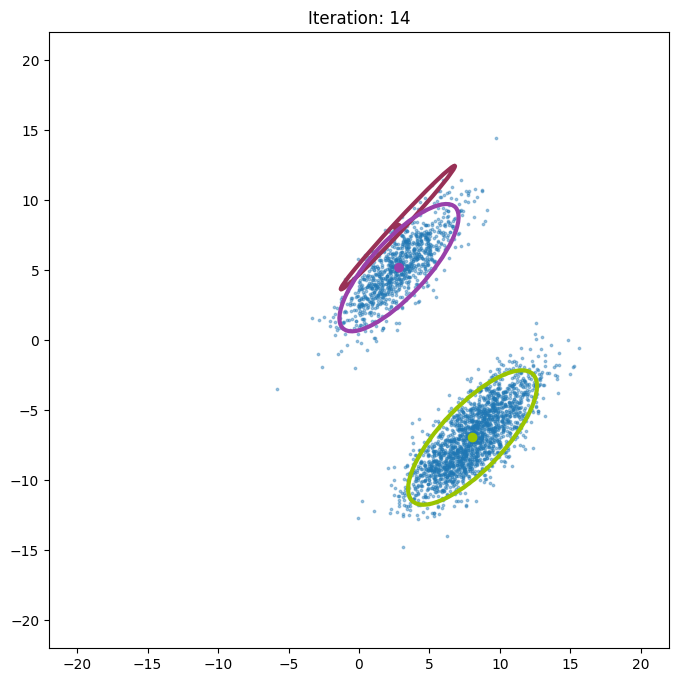

Iteration: 15, log-likelihood: -14017.8592


<Figure size 640x480 with 0 Axes>

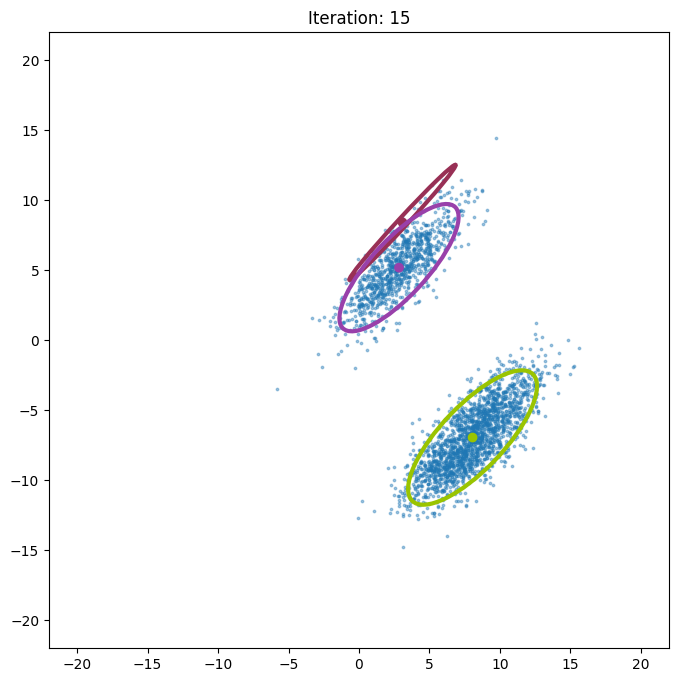

Iteration: 16, log-likelihood: -14017.8592


<Figure size 640x480 with 0 Axes>

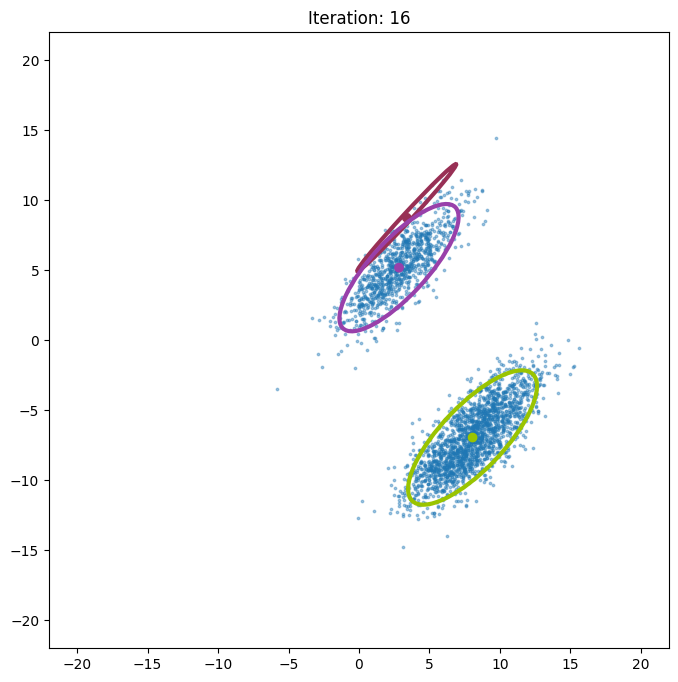

Iteration: 17, log-likelihood: -14017.8592


<Figure size 640x480 with 0 Axes>

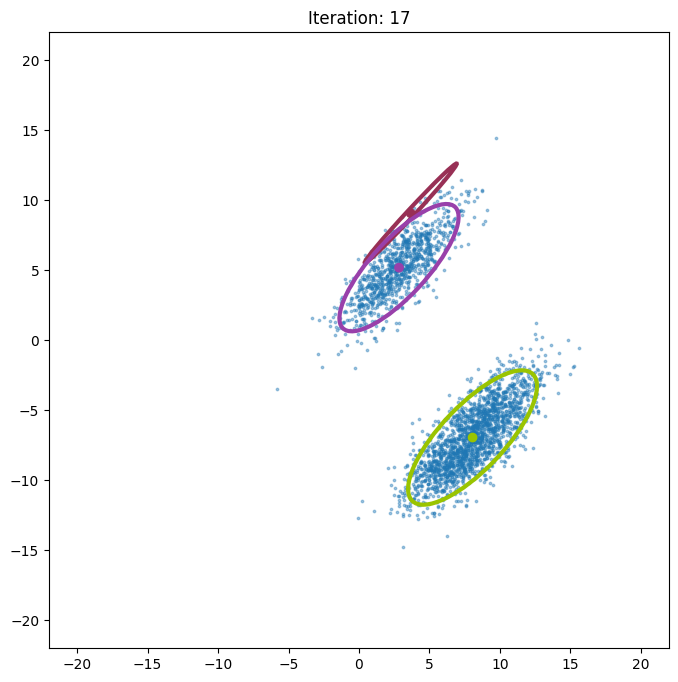

Iteration: 18, log-likelihood: -14017.8592


<Figure size 640x480 with 0 Axes>

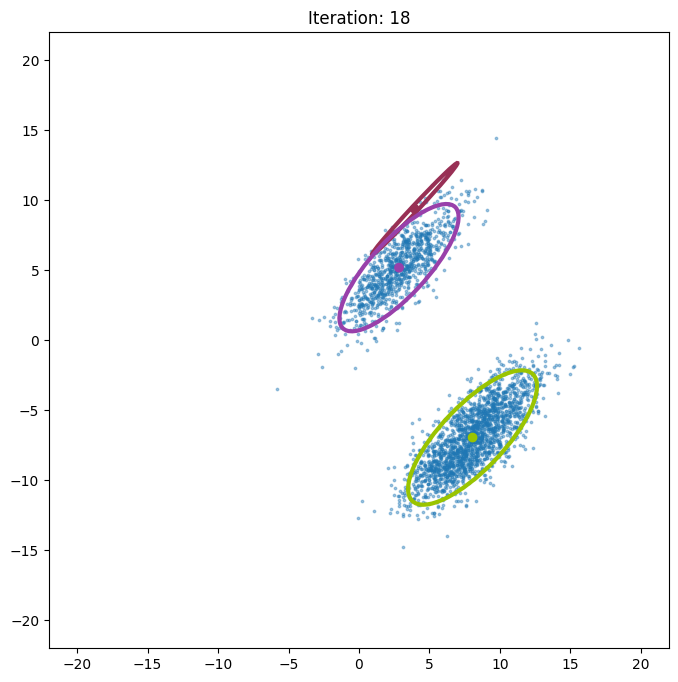

Iteration: 19, log-likelihood: -14017.8591


<Figure size 640x480 with 0 Axes>

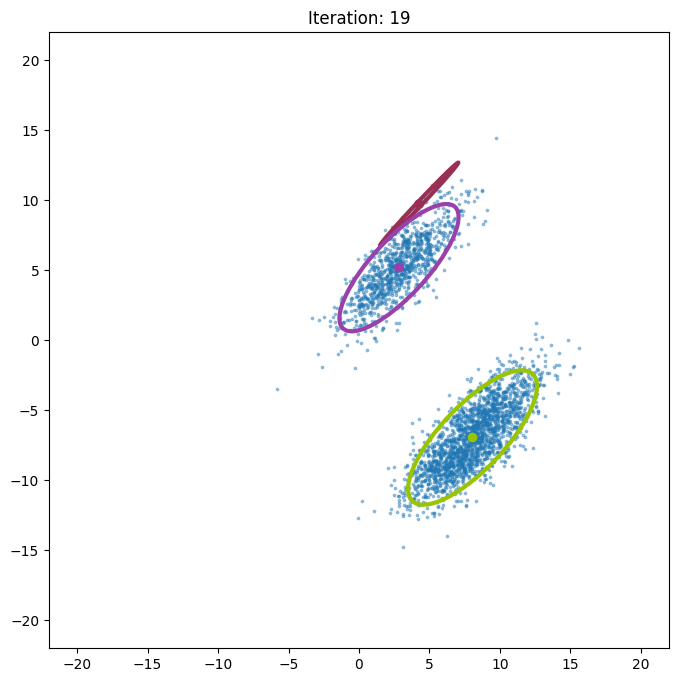

Iteration: 20, log-likelihood: -14017.8588


<Figure size 640x480 with 0 Axes>

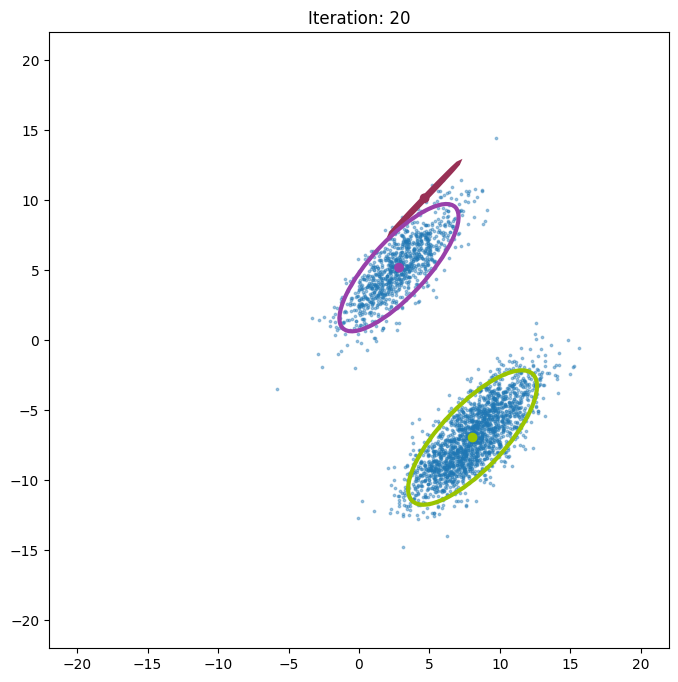

<Figure size 640x480 with 0 Axes>

In [9]:
# Training the GMM using EM

# Initialize EM algo with data
gmm.init_em(X)

num_iters = 20
# Saving log-likelihood
log_likelihood = [gmm.log_likelihood(X)]
# plotting
plot("Iteration:  0")
for e in range(num_iters):
    # E-step
    gmm.e_step()
    # M-step
    gmm.m_step()
    # Computing log-likelihood
    log_likelihood.append(gmm.log_likelihood(X))
    print("Iteration: {}, log-likelihood: {:.4f}".format(e+1, log_likelihood[-1]))
    # plotting
    plot(title="Iteration: " + str(e+1))

## Bai tap tu thuc hanh 1

In [12]:
import pandas as pd

# read data iris

data_iris = pd.read_csv('D:\\Machine Learning\\GMM\\data\\iris.csv')

data_iris.head()

sepal.length  sepal.width  petal.length  petal.width variety
0           5.1          3.5           1.4          0.2  Setosa
1           4.9          3.0           1.4          0.2  Setosa
2           4.7          3.2           1.3          0.2  Setosa
3           4.6          3.1           1.5          0.2  Setosa
4           5.0          3.6           1.4          0.2  Setosa

In [13]:
X_iris = data_iris.drop("variety", axis=1)
y_iris = data_iris['variety'].map({"Setosa": 0, "Versicolor": 1, "Virginica": 2})

X_iris.head()

sepal.length  sepal.width  petal.length  petal.width
0           5.1          3.5           1.4          0.2
1           4.9          3.0           1.4          0.2
2           4.7          3.2           1.3          0.2
3           4.6          3.1           1.5          0.2
4           5.0          3.6           1.4          0.2

In [16]:
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X_std = std.fit_transform(X_iris)
print(X_std.shape)

(150, 4)


In [18]:
X_std = np.array(X_std)

In [19]:
gmm_iris = GMM(3, 4)

In [20]:
gmm_iris.mu

array([[ 3.07147702, -0.61701288, -1.29809532, -5.12115716],
       [-2.7932564 ,  3.50090211, -2.50501777,  5.42448844],
       [-1.92197943,  2.83091018, -7.42786731,  0.61000772]])

In [22]:
gmm_iris.init_em(X_std)

num_iters = 20
# Saving log-likelihood
log_likelihood = [gmm_iris.log_likelihood(X_std)]

for e in range(num_iters):
    # E-step
    gmm_iris.e_step()
    # M-step
    gmm_iris.m_step()
    # Computing log-likelihood
    log_likelihood.append(gmm_iris.log_likelihood(X_std))
    print("Iteration: {}, log-likelihood: {:.4f}".format(e+1, log_likelihood[-1]))

Iteration: 1, log-likelihood: -296.9155
Iteration: 2, log-likelihood: -296.9153
Iteration: 3, log-likelihood: -296.9152
Iteration: 4, log-likelihood: -296.9151
Iteration: 5, log-likelihood: -296.9151
Iteration: 6, log-likelihood: -296.9151
Iteration: 7, log-likelihood: -296.9151
Iteration: 8, log-likelihood: -296.9151
Iteration: 9, log-likelihood: -296.9150
Iteration: 10, log-likelihood: -296.9150
Iteration: 11, log-likelihood: -296.9150
Iteration: 12, log-likelihood: -296.9150
Iteration: 13, log-likelihood: -296.9150
Iteration: 14, log-likelihood: -296.9150
Iteration: 15, log-likelihood: -296.9150
Iteration: 16, log-likelihood: -296.9150
Iteration: 17, log-likelihood: -296.9150
Iteration: 18, log-likelihood: -296.9150
Iteration: 19, log-likelihood: -296.9150
Iteration: 20, log-likelihood: -296.9150


In [23]:
y_pred = np.argmax(gmm_iris.z, axis=1)
print(y_pred)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 1 1
 1 1 1 1 1 0 0 0 0 1 1 0 1 1 0 1 1 1 0 0 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1]


In [24]:
print("Silhouette score:", silhouette_score(X_std, y_pred))

Silhouette score: 0.3229541245993946


## Bai tap tu thuc hanh 2

In [25]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from scipy.stats import multivariate_normal

from sklearn.cluster import KMeans
from matplotlib.patches import Ellipse
from sklearn.metrics import davies_bouldin_score

In [26]:
def gen_data(k=3, dim=2, points_per_cluster=200, lim=[-10, 10]):
    '''
    Generates data from a random mixture of Gaussians in a given range.
    Will also plot the points in case of 2D.
    input:
        - k: Number of Gaussian clusters
        - dim: Dimension of generated points
        - points_per_cluster: Number of points to be generated for each cluster
        - lim: Range of mean values
    output:
        - X: Generated points (points_per_cluster*k, dim)
    '''
    x = []
    mean = random.rand(k, dim)*(lim[1]-lim[0]) + lim[0]
    for i in range(k):
        cov = random.rand(dim, dim+10)
        cov = np.matmul(cov, cov.T)
        _x = np.random.multivariate_normal(mean[i], cov, points_per_cluster)
        x += list(_x)
    x = np.array(x)
    if(dim == 2):
        fig = plt.figure()
        ax = fig.gca()
        ax.scatter(x[:,0], x[:,1], s=3, alpha=0.4)
        ax.autoscale(enable=True) 
    return x

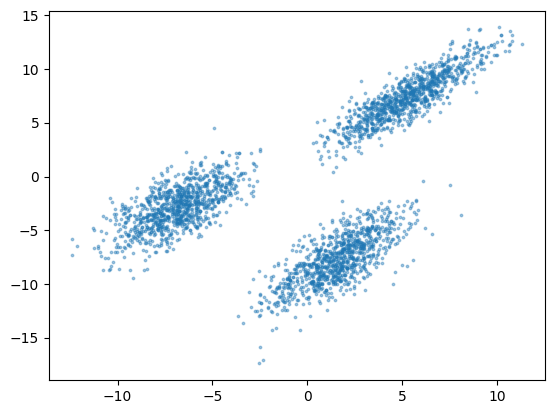

In [27]:
# Generate random 2D data with 3 clusters 
X = gen_data(k=3, dim=2, points_per_cluster=1000)

In [28]:
# Create a Gaussian Mixture Model
gmm = GMM(3, 2)

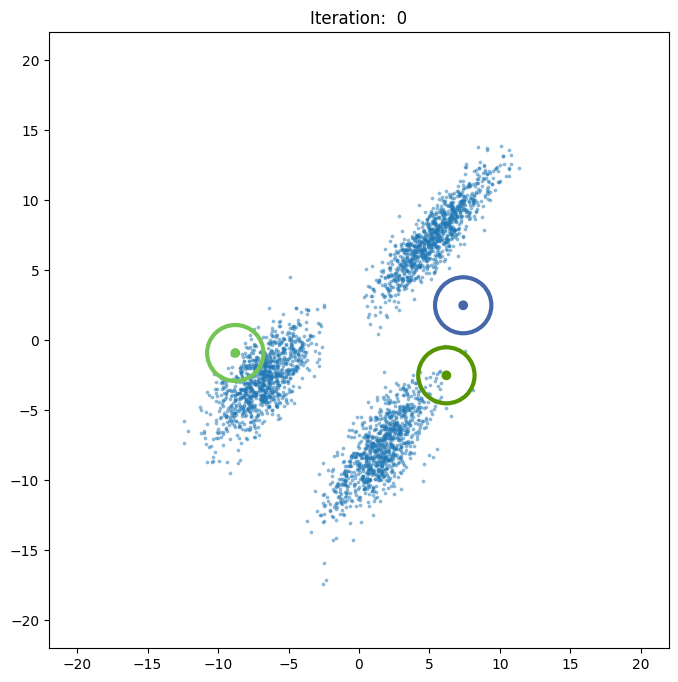

Iteration: 1, log-likelihood: -14695.9917


<Figure size 640x480 with 0 Axes>

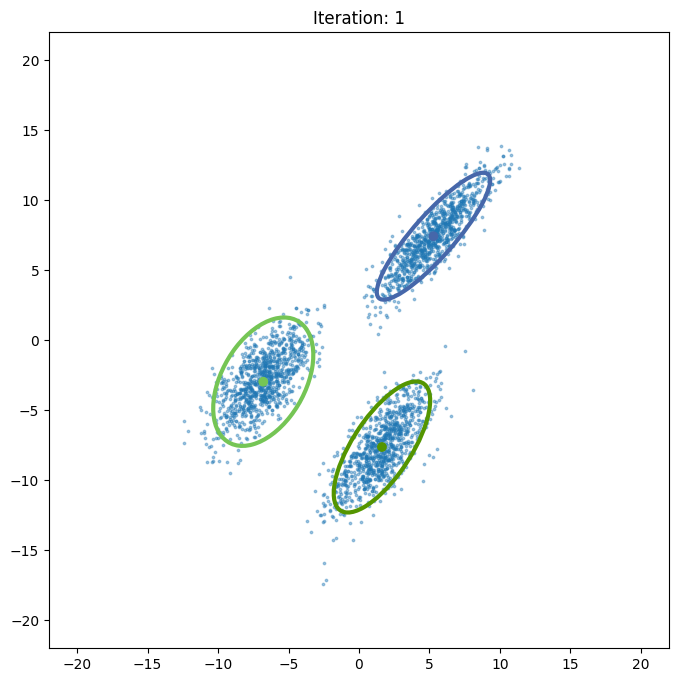

Iteration: 2, log-likelihood: -14586.9615


<Figure size 640x480 with 0 Axes>

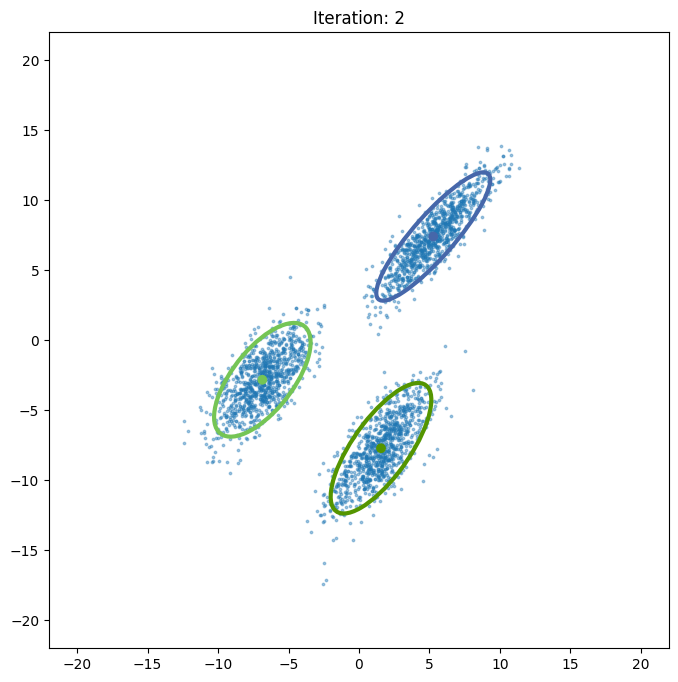

Iteration: 3, log-likelihood: -14586.9614


<Figure size 640x480 with 0 Axes>

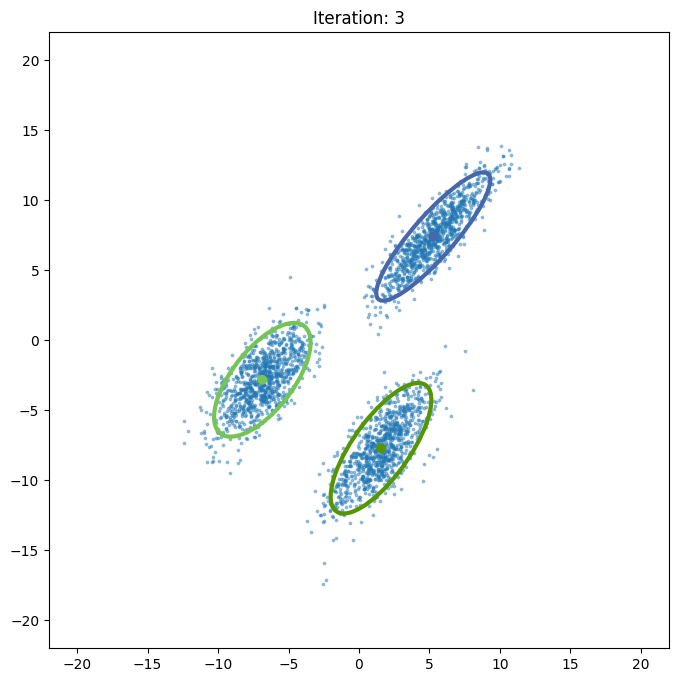

Iteration: 4, log-likelihood: -14586.9614


<Figure size 640x480 with 0 Axes>

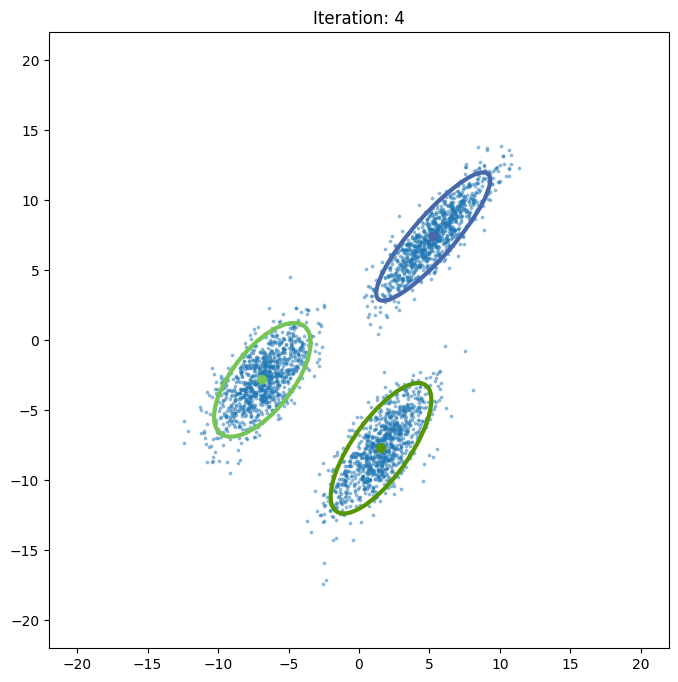

Iteration: 5, log-likelihood: -14586.9614


<Figure size 640x480 with 0 Axes>

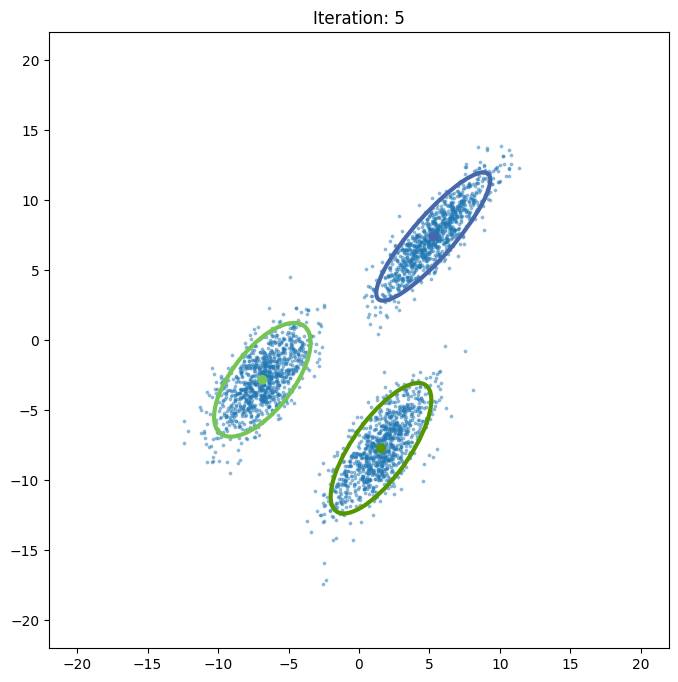

Iteration: 6, log-likelihood: -14586.9614


<Figure size 640x480 with 0 Axes>

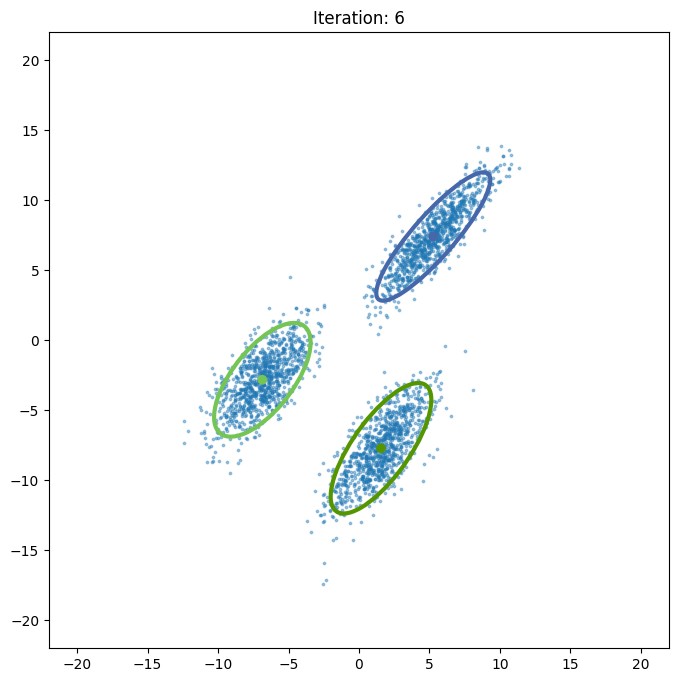

Iteration: 7, log-likelihood: -14586.9614


<Figure size 640x480 with 0 Axes>

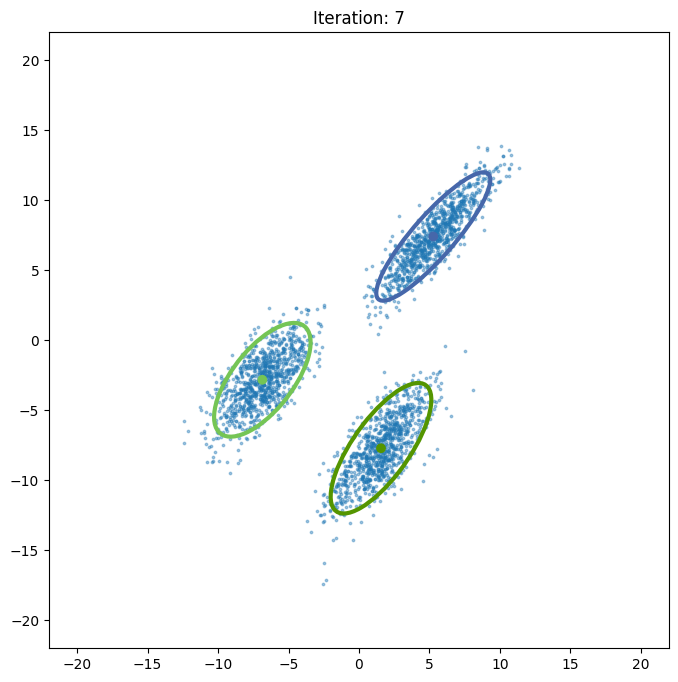

Iteration: 8, log-likelihood: -14586.9614


<Figure size 640x480 with 0 Axes>

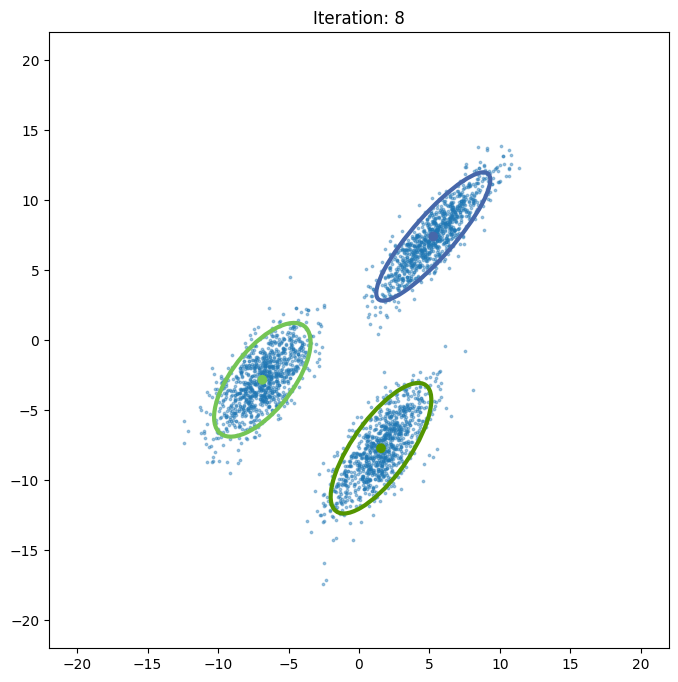

Iteration: 9, log-likelihood: -14586.9614


<Figure size 640x480 with 0 Axes>

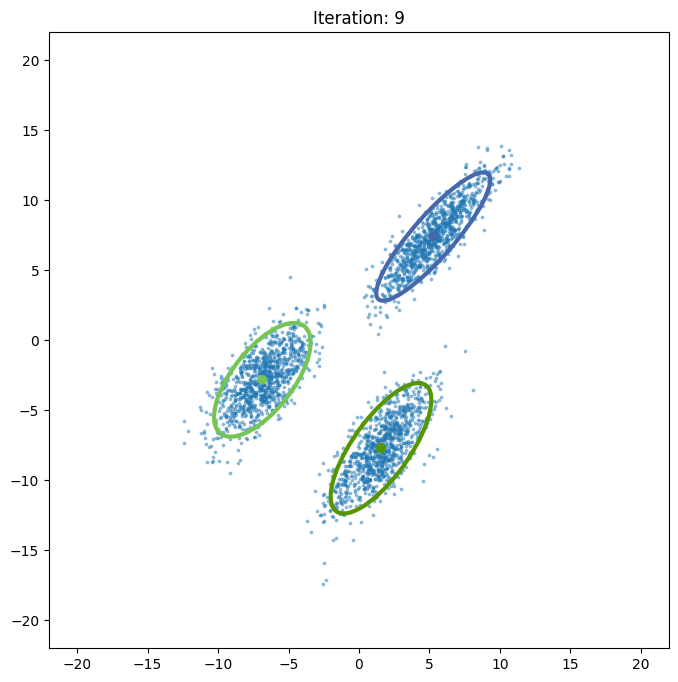

Iteration: 10, log-likelihood: -14586.9614


<Figure size 640x480 with 0 Axes>

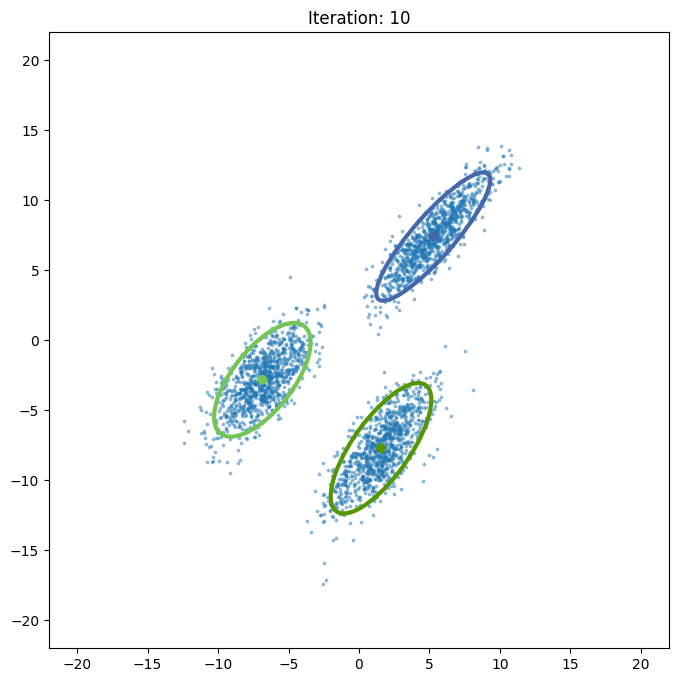

Iteration: 11, log-likelihood: -14586.9614


<Figure size 640x480 with 0 Axes>

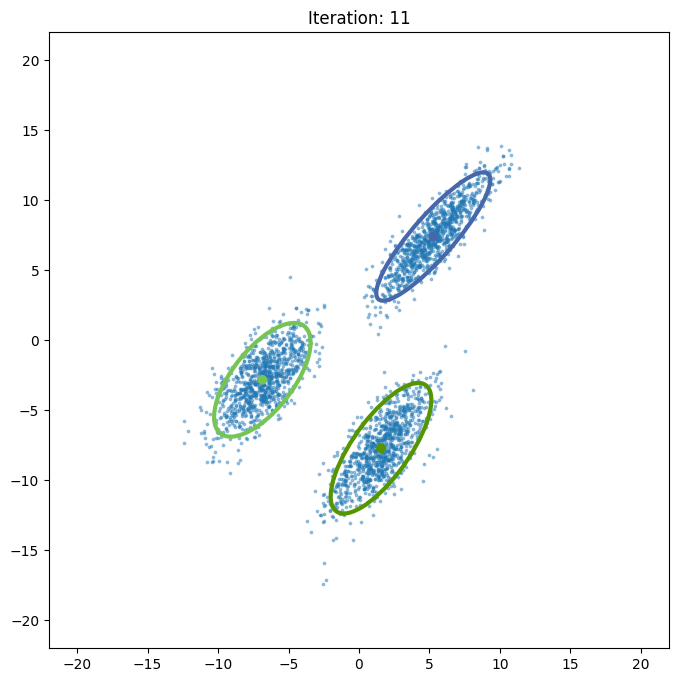

Iteration: 12, log-likelihood: -14586.9614


<Figure size 640x480 with 0 Axes>

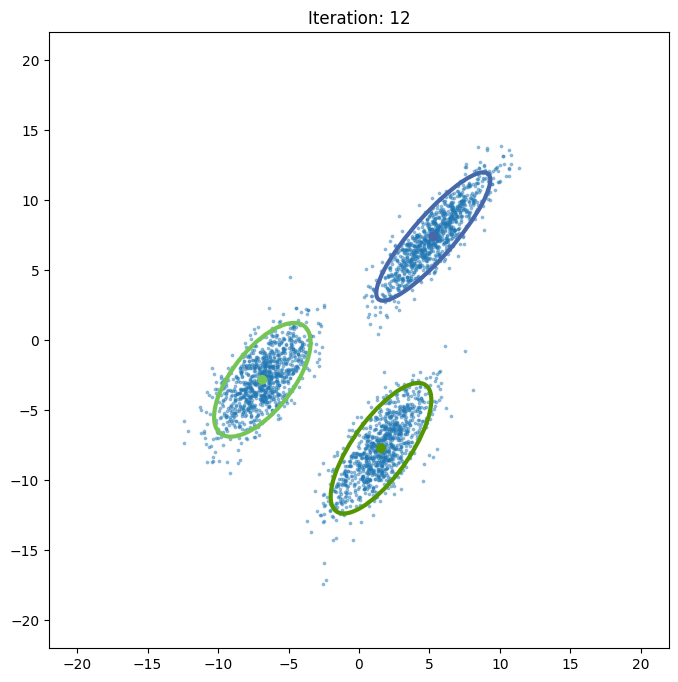

Iteration: 13, log-likelihood: -14586.9614


<Figure size 640x480 with 0 Axes>

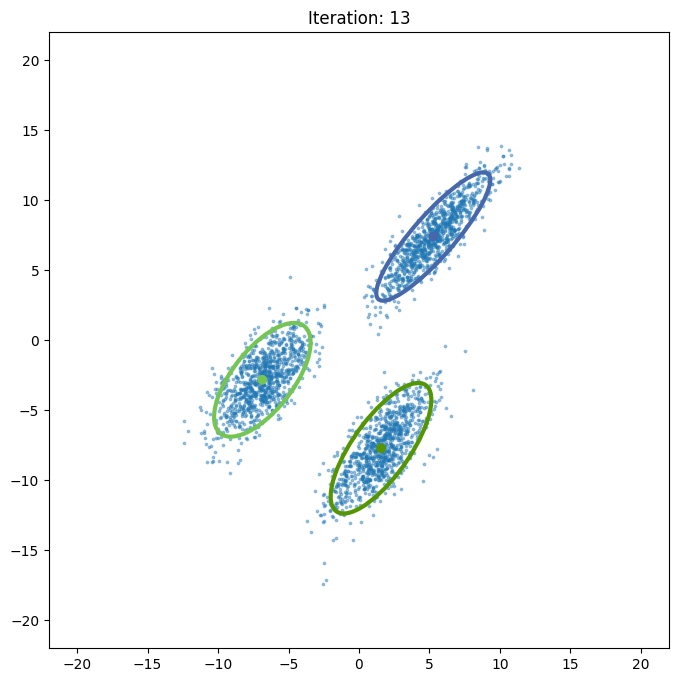

Iteration: 14, log-likelihood: -14586.9614


<Figure size 640x480 with 0 Axes>

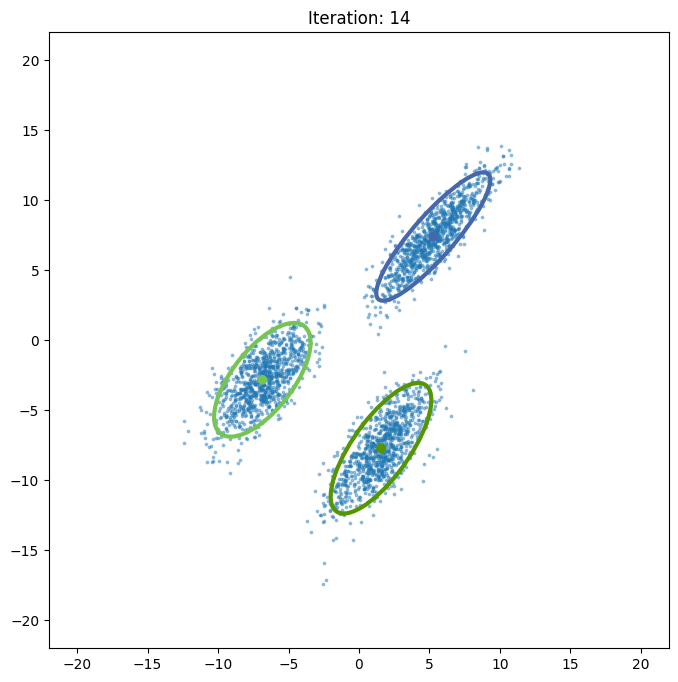

Iteration: 15, log-likelihood: -14586.9614


<Figure size 640x480 with 0 Axes>

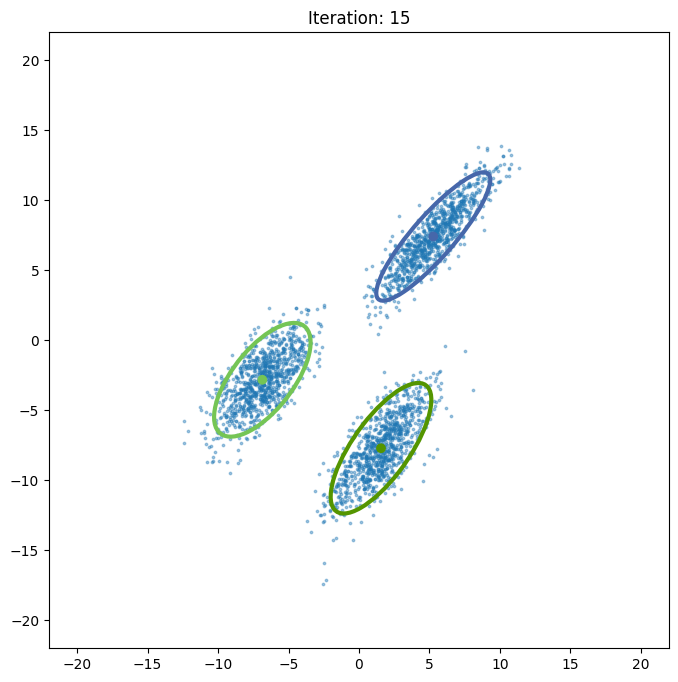

Iteration: 16, log-likelihood: -14586.9614


<Figure size 640x480 with 0 Axes>

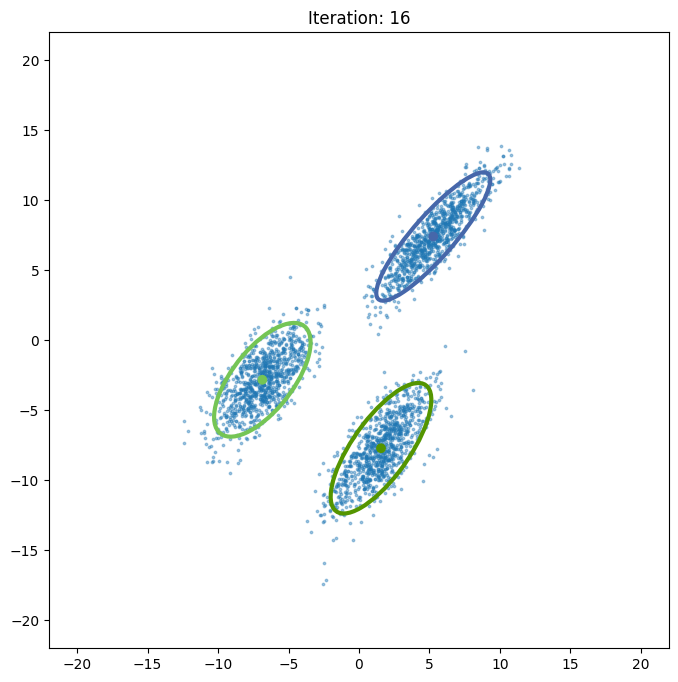

Iteration: 17, log-likelihood: -14586.9614


<Figure size 640x480 with 0 Axes>

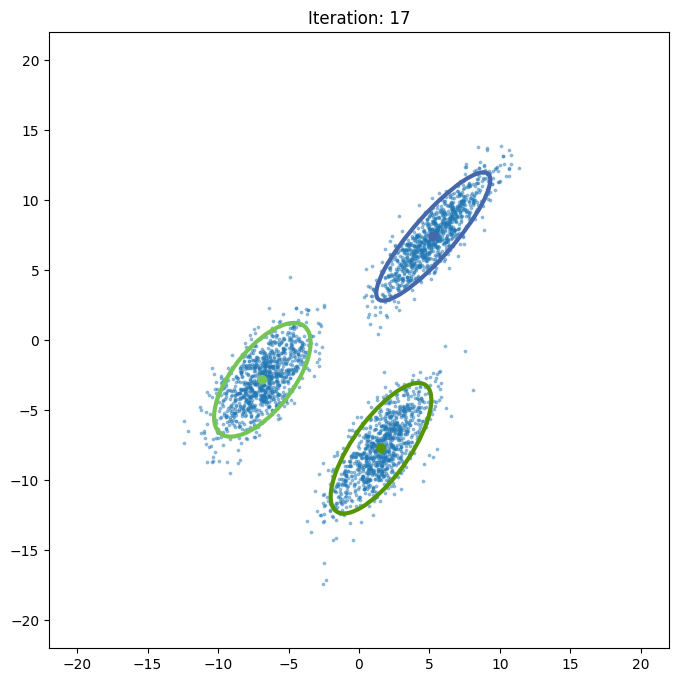

Iteration: 18, log-likelihood: -14586.9614


<Figure size 640x480 with 0 Axes>

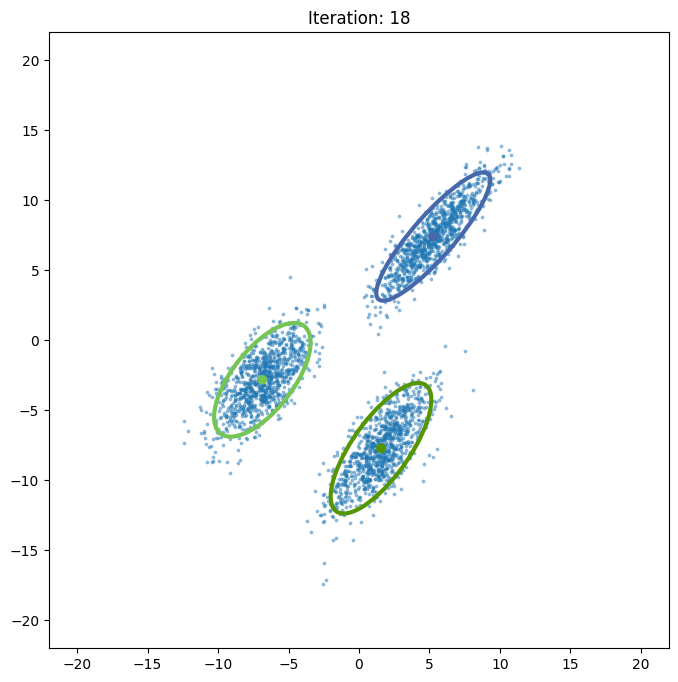

Iteration: 19, log-likelihood: -14586.9614


<Figure size 640x480 with 0 Axes>

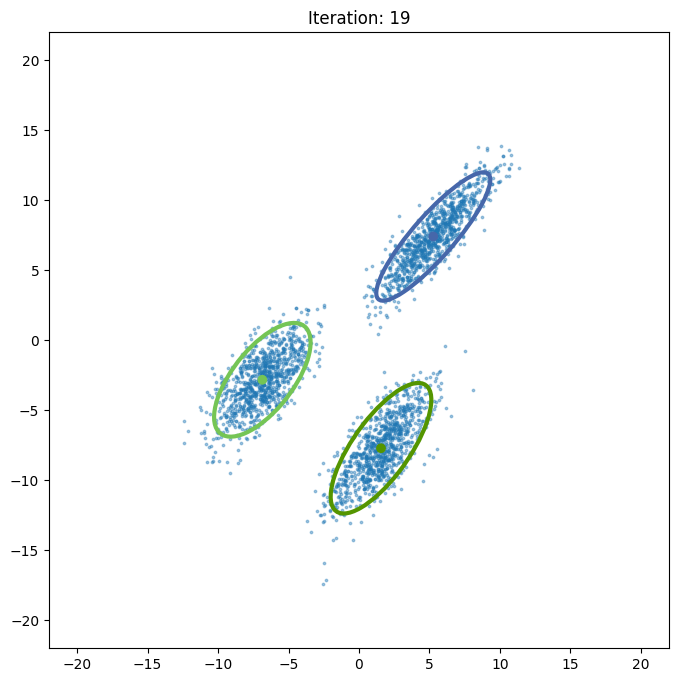

Iteration: 20, log-likelihood: -14586.9614


<Figure size 640x480 with 0 Axes>

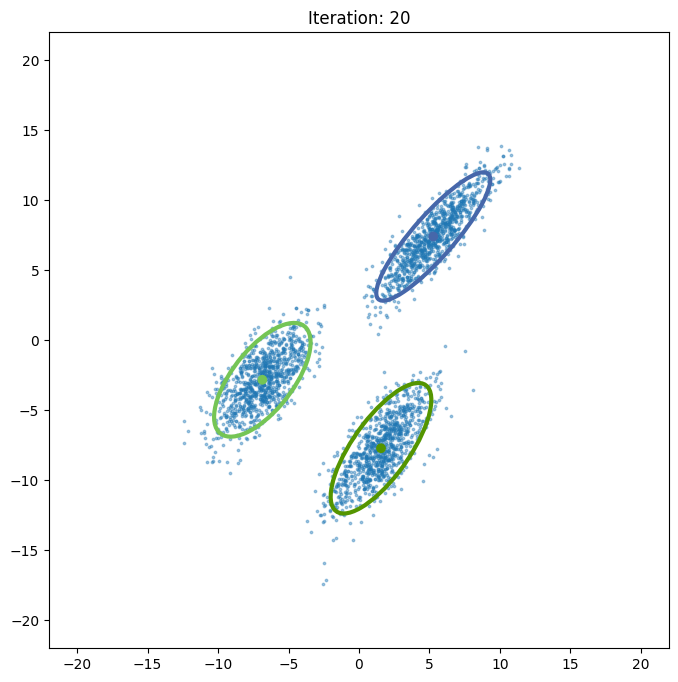

<Figure size 640x480 with 0 Axes>

In [29]:
# Training the GMM using EM

# Initialize EM algo with data
gmm.init_em(X)

num_iters = 20
# Saving log-likelihood
log_likelihood = [gmm.log_likelihood(X)]
# plotting
plot("Iteration:  0")
for e in range(num_iters):
    # E-step
    gmm.e_step()
    # M-step
    gmm.m_step()
    # Computing log-likelihood
    log_likelihood.append(gmm.log_likelihood(X))
    print("Iteration: {}, log-likelihood: {:.4f}".format(e+1, log_likelihood[-1]))
    # plotting
    plot(title="Iteration: " + str(e+1))

In [30]:
y_pred_gmm = np.argmax(gmm.z, axis=1)
print(y_pred_gmm)

[0 0 0 ... 2 2 2]


In [31]:
print("Davies Bouldin Score:", davies_bouldin_score(X, y_pred_gmm))

Davies Bouldin Score: 0.434042656008057


In [32]:
kmeans = KMeans(n_clusters=3)

kmeans.fit(X)

KMeans(n_clusters=3)

In [33]:
y_pred_kmeans = kmeans.predict(X)
print(y_pred_kmeans)

[0 0 0 ... 2 2 2]


In [34]:
print("Davies Bouldin Score:", davies_bouldin_score(X, y_pred_kmeans))

Davies Bouldin Score: 0.4331780503489641


Nhận xét:

DB Score có ý nghĩa:

Giá trị thấp: Phân cụm tốt (Các cụm gắn kết hơn và tách biệt hơn).

Giá trị cao: Phân cụm kém (Các cum chồng lấn hoặc phân tán hơn).

Kết quả:

GMM: DB Score = 0.4334

KMeans: DB Score = 0.4331

Giá trị DB Score của KMeans thấp hơn, cho thấy KMeans tạo ra các cụm có độ gắn kết trong cụm cao hơn và/hoặc tách biệt giữa các cụm tốt hơn so với GMM trên cùng tập dữ liệu

## Bai thuc hanh 2.2

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import warnings
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from matplotlib.patches import Ellipse
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score

warnings.filterwarnings('ignore')

In [38]:
data = pd.read_csv("D:\\Machine Learning\\GMM\\data\\shopping-data.csv", header=0, index_col=0)

data.head()

Genre  Age  Annual Income (k$)  Spending Score (1-100)
CustomerID                                                         
1             Male   19                  15                      39
2             Male   21                  15                      81
3           Female   20                  16                       6
4           Female   23                  16                      77
5           Female   31                  17                      40

In [39]:
X = data.iloc[:, 2:4].values

std = MinMaxScaler()
X_std = std.fit_transform(X)
print(X_std.shape)

(200, 2)


In [40]:
# Khởi tạo đối tượng mô hình GaussianMixture
gm = GaussianMixture(n_components=5,
covariance_type='full',
random_state=0)

gm.fit(X_std)
print('means: \n', gm.means_)
print('covariances: \n ', gm.covariances_)

means: 
 [[0.33368985 0.49394756]
 [0.60502531 0.15433196]
 [0.58393969 0.82673863]
 [0.09861098 0.21597752]
 [0.0829305  0.80743088]]
covariances: 
  [[[ 0.00613567 -0.00231927]
  [-0.00231927  0.0051635 ]]

 [[ 0.01818446  0.00433814]
  [ 0.00433814  0.00873064]]

 [[ 0.01808598 -0.00031096]
  [-0.00031096  0.0091568 ]]

 [[ 0.00453005  0.00255303]
  [ 0.00255303  0.01918353]]

 [[ 0.00337483 -0.0001437 ]
  [-0.0001437   0.01026088]]]


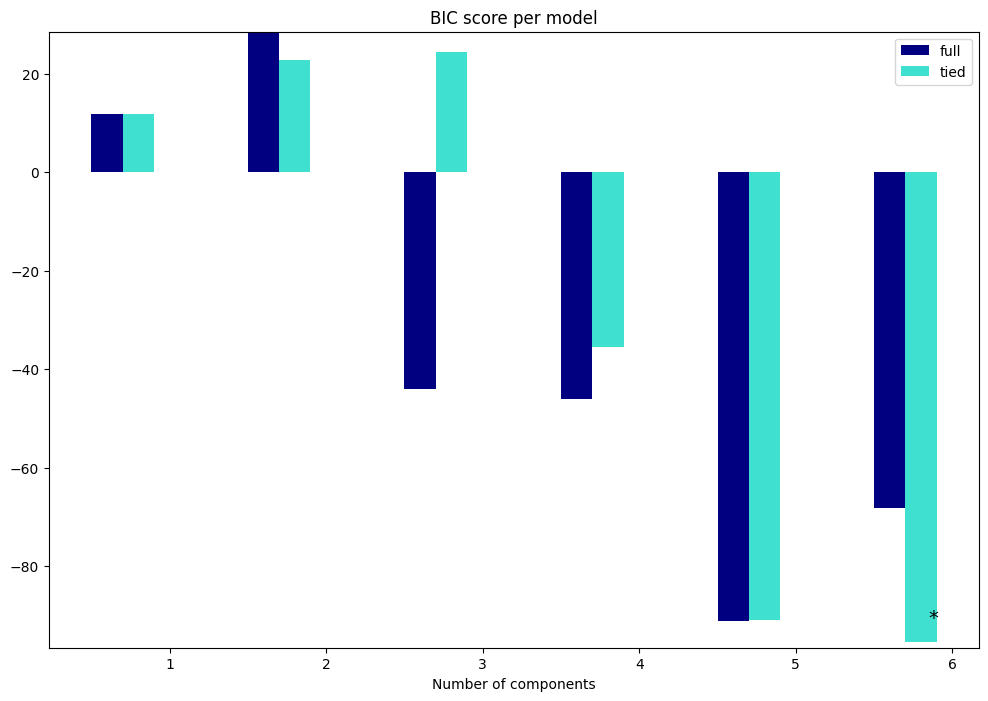

In [41]:
lowest_bic = np.inf
bic = []
n_components_range = range(1, 7)
# cv_types = ['spherical', 'tied', 'diag', 'full']
cv_types = ['full', 'tied']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit Gaussian mixture theo phương pháp huấn luyện EM
        gmm = GaussianMixture(n_components=n_components, covariance_type=cv_type)
        gmm.fit(X_std)
        bic.append(gmm.bic(X_std))
        # Gán model có BIC scores thấp nhất là model tốt nhất
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise'])
clf = best_gmm
bars = []

# Vẽ biểu đồ BIC scores
plt.figure(figsize=(12, 8))
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                    (i + 1) * len(n_components_range)], width=.2, color=color))

plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 + .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
plt.xlabel('Number of components')
plt.legend([b[0] for b in bars], cv_types)

In [42]:
def _plot_kmean_scatter(X, labels):
    '''
    X: dữ liệu đầu vào
    labels: nhãn dự báo
    '''
    # lựa chọn màu sắc
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("hls", num_classes))
    
    # vẽ biểu đồ scatter
    fig = plt.figure(figsize=(12, 8))
    ax = plt.subplot()
    sc = ax.scatter(X[:,0], X[:,1], lw=0, s=40, c=palette[labels.astype(np.int64)])

    # thêm nhãn cho mỗi cluster
    txts = []
    
    for i in range(num_classes):
        # Vẽ text tên cụm tại trung vị của mỗi cụm
        xtext, ytext = np.median(X[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
    plt.title('t-sne visualization')

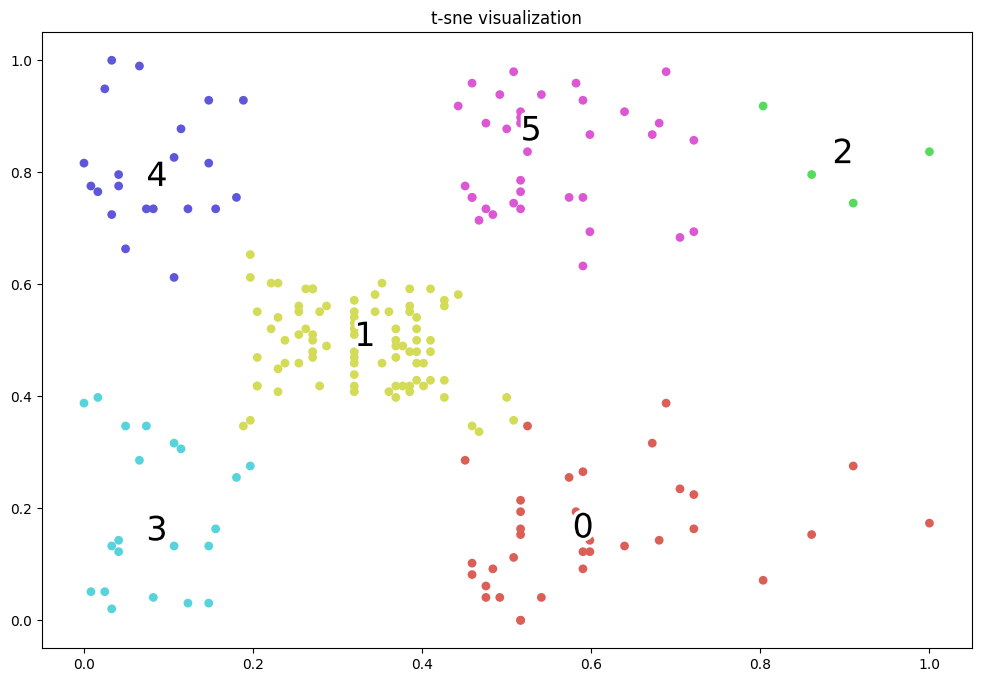

In [43]:
labels = best_gmm.predict(X_std)
_plot_kmean_scatter(X_std, labels)

In [44]:
print("Silhouette Score:", silhouette_score(X_std, labels))

Silhouette Score: 0.5481527496436199


In [45]:
print("Davies Bouldin Score:", davies_bouldin_score(X_std, labels))

Davies Bouldin Score: 0.5757525747762112


#### K-Means

In [47]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_std)

print('Centers found by scikit-learn:')
print(kmeans.cluster_centers_)

pred_label = kmeans.predict(X_std)

print(pred_label)

Centers found by scikit-learn:
[[0.33029751 0.49508692]
 [0.6        0.16443149]
 [0.58638083 0.82783883]
 [0.09265859 0.20319432]
 [0.08792846 0.79962894]]
[3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3
 4 3 4 3 4 3 0 3 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 2 1 2 0 2 1 2 1 2 0 2 1 2 1 2 1 2 1 2 0 2 1 2 1 2
 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2]


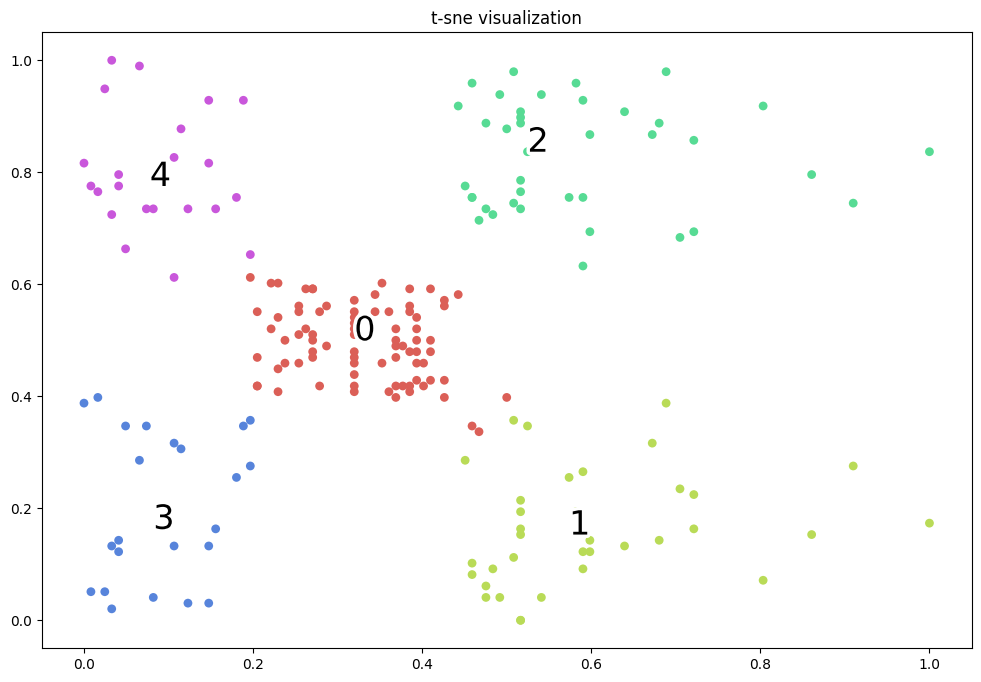

In [48]:
_plot_kmean_scatter(X_std, pred_label)

In [49]:
print("Silhouette Score:", silhouette_score(X_std, pred_label))

Silhouette Score: 0.5594854531227246


In [50]:
print("Davies Bouldin Score:", davies_bouldin_score(X_std, pred_label))

Davies Bouldin Score: 0.5678112087671997


## Bai tu thuc hanh 2.3

In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import warnings
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from matplotlib.patches import Ellipse
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score

warnings.filterwarnings('ignore')

In [52]:
data = pd.read_csv("D:\\Machine Learning\\GMM\\data\\Sales_Transactions_Dataset_Weekly.csv", header=0, index_col=0)

data.head()

W0  W1  W2  W3  W4  W5  W6  W7  W8  W9  ...  Normalized 42  \
Product_Code                                          ...                  
P1            11  12  10   8  13  12  14  21   6  14  ...           0.06   
P2             7   6   3   2   7   1   6   3   3   3  ...           0.20   
P3             7  11   8   9  10   8   7  13  12   6  ...           0.27   
P4            12   8  13   5   9   6   9  13  13  11  ...           0.41   
P5             8   5  13  11   6   7   9  14   9   9  ...           0.27   

              Normalized 43  Normalized 44  Normalized 45  Normalized 46  \
Product_Code                                                               
P1                     0.22           0.28           0.39           0.50   
P2                     0.40           0.50           0.10           0.10   
P3                     1.00           0.18           0.18           0.36   
P4                     0.47           0.06           0.12           0.24   
P5                     0.53           0.27           0.60           0.20   

              Normalized 47  Normalized 48  Normalized 49  Normalized 50  \
Product_Code                                                               
P1                     0.00           0.22           0.17           0.11   
P2                     0.40           0.50           0.10           0.60   
P3                     0.45           1.00           0.45           0.45   
P4                     0.35           0.71           0.35           0.29   
P5                     0.20           0.13           0.53           0.33   

              Normalized 51  
Product_Code                 
P1                     0.39  
P2                     0.00  
P3                     0.36  
P4                     0.35  
P5                     0.40  

[5 rows x 106 columns]

In [53]:
X = data.iloc[:, 2:].values

std = MinMaxScaler()
X_std = std.fit_transform(X)
print(X_std.shape)

(811, 104)


#### EM

In [54]:
# Khởi tạo đối tượng mô hình GaussianMixture
gm = GaussianMixture(n_components=5,
covariance_type='full',
random_state=0)

gm.fit(X_std)
print('means: \n', gm.means_)
print('covariances: \n ', gm.covariances_)

means: 
 [[1.40019244e-02 1.13486079e-02 1.27097962e-02 1.49095687e-02
  1.40019244e-02 1.12258996e-02 1.18866613e-02 1.49095685e-02
  1.22713494e-02 1.34471468e-02 1.19876487e-02 1.77013947e-02
  1.51473608e-02 1.01541284e-02 1.03749012e-02 8.87668847e-03
  1.65384450e-02 1.24285440e-02 1.26646620e-02 1.57225054e-02
  1.88294991e-02 1.66414882e-02 2.27135675e-02 2.77390246e-02
  1.72371883e-02 1.83702035e-02 2.08261991e-02 2.26546251e-02
  1.90887659e-02 2.06194607e-02 2.24748500e-02 2.45151793e-02
  2.61443891e-02 2.22170252e-02 2.11462847e-02 2.36188331e-02
  2.32114876e-02 2.43686374e-02 2.73483280e-02 2.06158671e-02
  2.16866453e-02 2.44923550e-02 3.21763814e-02 2.92086475e-02
  2.57897242e-02 2.71497989e-02 3.30392416e-02 3.38016247e-02
  3.46222825e-02 4.15179175e-02 1.46836661e-03 4.87625959e-02
  1.35588973e-01 1.11537128e-01 1.33738829e-01 1.23515346e-01
  1.74265749e-01 1.35853279e-01 1.59376510e-01 1.38232033e-01
  1.69680792e-01 1.49773390e-01 1.40610784e-01 1.63341102e-01

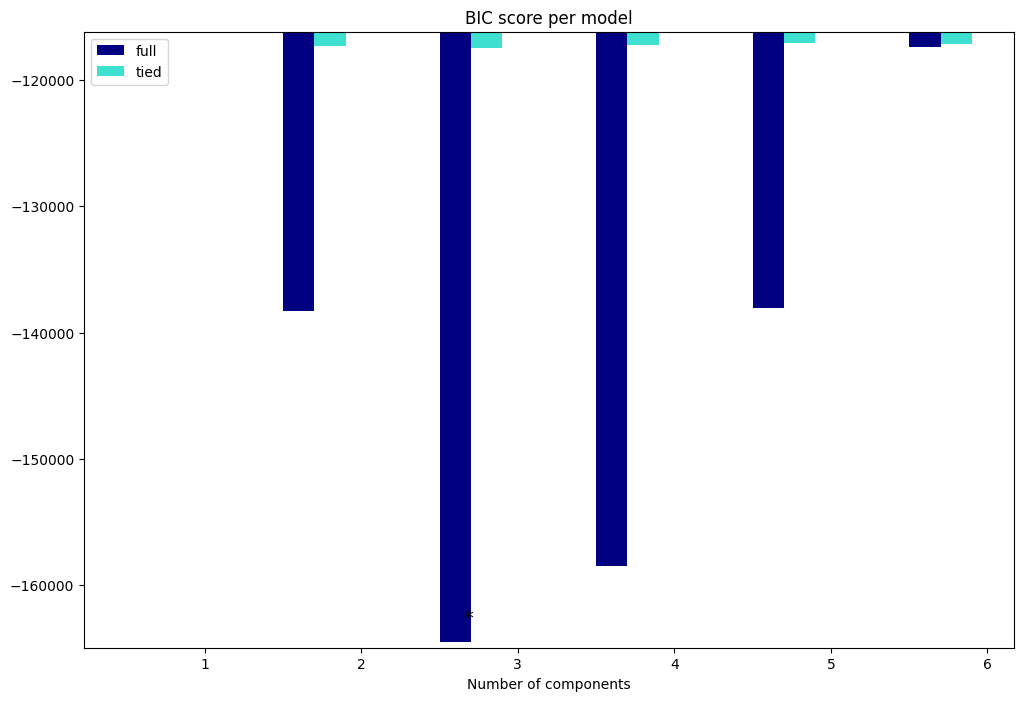

In [55]:
lowest_bic = np.inf
bic = []
n_components_range = range(1, 7)
# cv_types = ['spherical', 'tied', 'diag', 'full']
cv_types = ['full', 'tied']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit Gaussian mixture theo phương pháp huấn luyện EM
        gmm = GaussianMixture(n_components=n_components, covariance_type=cv_type)
        gmm.fit(X_std)
        bic.append(gmm.bic(X_std))
        # Gán model có BIC scores thấp nhất là model tốt nhất
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise'])
clf = best_gmm
bars = []

# Vẽ biểu đồ BIC scores
plt.figure(figsize=(12, 8))
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                    (i + 1) * len(n_components_range)], width=.2, color=color))

plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 + .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
plt.xlabel('Number of components')
plt.legend([b[0] for b in bars], cv_types)

In [56]:
def _plot_kmean_scatter(X, labels):
    '''
    X: dữ liệu đầu vào
    labels: nhãn dự báo
    '''
    # lựa chọn màu sắc
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("hls", num_classes))
    
    # vẽ biểu đồ scatter
    fig = plt.figure(figsize=(12, 8))
    ax = plt.subplot()
    sc = ax.scatter(X[:,0], X[:,1], lw=0, s=40, c=palette[labels.astype(np.int64)])

    # thêm nhãn cho mỗi cluster
    txts = []
    
    for i in range(num_classes):
        # Vẽ text tên cụm tại trung vị của mỗi cụm
        xtext, ytext = np.median(X[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
    plt.title('t-sne visualization')

ValueError: too many values to unpack (expected 2)

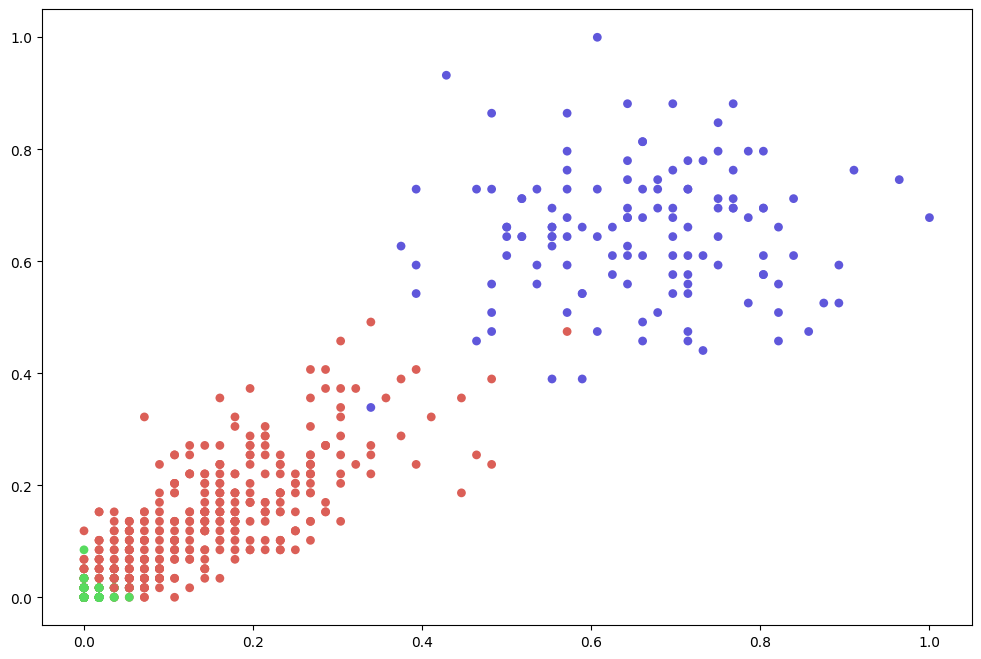

In [57]:
labels = best_gmm.predict(X_std)
_plot_kmean_scatter(X_std, labels)